### GREEKS

https://www.smileofthales.com/computation/options-greeks-python/

In [3]:
import numpy as np
from math import sqrt, pi,log, e
from enum import Enum
import scipy.stats as stat
from scipy.stats import norm
import time
 
class BSMerton:
    def __init__(self, args):
        self.Type = int(args[0])                # 1 for a Call, - 1 for a put
        self.S = float(args[1])                 # Underlying asset price
        self.K = float(args[2])                 # Option strike K
        self.r = float(args[3])                 # Continuous risk fee rate
        self.q = float(args[4])                 # Dividend continuous rate
        self.T = float(args[5]) / 365.0         # Compute time to expiry
        self.sigma = float(args[6])             # Underlying volatility
        self.sigmaT = self.sigma * self.T ** 0.5# sigma*T for reusability
        self.d1 = (log(self.S / self.K) + \
                   (self.r - self.q + 0.5 * (self.sigma ** 2))  * self.T) / self.sigmaT
        self.d2 = self.d1 - self.sigmaT
        [self.Premium] = self.premium()
        [self.Delta] = self.delta()
        [self.Theta] = self.theta()
        [self.Rho] = self.rho()
        [self.Vega] = self.vega()
        [self.Gamma] = self.gamma()
        [self.Phi] = self.phi()
        [self.Charm] = self.dDeltadTime()
        [self.Vanna] = self.dDeltadVol()
 
    def premium(self):
        tmpprem = self.Type * (self.S * e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1) - self.K * e ** (-self.r * self.T) * norm.cdf(self.Type * self.d2))
        return [tmpprem]
 
    ############################################
    ############ 1st order greeks ##############
    ############################################
 
    def delta(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [dfq * norm.cdf(self.d1)]
        else:
            return [dfq * (norm.cdf(self.d1) - 1)]
 
    # Vega for 1% change in vol
    def vega(self):
        return [0.01 * self.S * e ** (-self.q * self.T) * \
          norm.pdf(self.d1) * self.T ** 0.5]
 
    # Theta for 1 day change
    def theta(self):
        df = e ** -(self.r * self.T)
        dfq = e ** (-self.q * self.T)
        tmptheta = (1.0 / 365.0) \
            * (-0.5 * self.S * dfq * norm.pdf(self.d1) * \
               self.sigma / (self.T ** 0.5) + \
               self.Type * (self.q * self.S * dfq * norm.cdf(self.Type * self.d1) \
            - self.r * self.K * df * norm.cdf(self.Type * self.d2)))
        return [tmptheta]
 
    def rho(self):
        df = e ** -(self.r * self.T)
        return [self.Type * self.K * self.T * df * 0.01 * norm.cdf(self.Type * self.d2)]
 
    def phi(self):
        return [0.01* -self.Type * self.T * self.S * \
             e ** (-self.q * self.T) * norm.cdf(self.Type * self.d1)]
 
    ############################################
    ############ 2nd order greeks ##############
    ############################################
 
    def gamma(self):
        return [e ** (-self.q * self.T) * norm.pdf(self.d1) / (self.S * self.sigmaT)]
 
    # Charm for 1 day change
    def dDeltadTime(self):
        dfq = e ** (-self.q * self.T)
        if self.Type == 1:
            return [(1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r-self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                            + (-self.q) * norm.cdf(self.d1))]
        else:
            return [(1.0 / 365.0) * -dfq * (norm.pdf(self.d1) * ((self.r-self.q) / (self.sigmaT) - self.d2 / (2 * self.T)) \
                            + self.q * norm.cdf(-self.d1))]
 
    # Vanna for 1% change in vol
    def dDeltadVol(self):
        return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]
 
    # Vomma
    def dVegadVol(self):
        return [0.01 * -e ** (-self.q * self.T) * self.d2 / self.sigma * norm.pdf(self.d1)]

Calculating greeks ...
Plotting surface ...


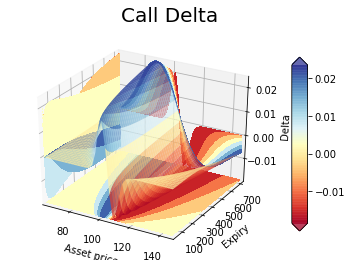

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
#import OptionsAnalytics
#from OptionsAnalytics import BSMerton
 
# Option parameters
sigma = 0.12        # Flat volatility
strike = 105.0      # Fixed strike
epsilon = 0.4       # The % on the left/right of Strike. 
                    # Asset prices are centered around Spot ("ATM Spot")
shortexpiry = 30    # Shortest expiry in days
longexpiry = 720    # Longest expiry in days
riskfree = 0.00     # Continuous risk free rate
divrate = 0.00      # Continuous div rate
 
# Grid definition
dx, dy = 40, 40     # Steps throughout asset price and expiries axis
 
# xx: Asset price axis, yy: expiry axis, zz: greek axis
xx, yy = np.meshgrid(np.linspace(strike*(1-epsilon), (1+epsilon)*strike, dx), \
    np.linspace(shortexpiry, longexpiry, dy))
print( "Calculating greeks ...")
zz = np.array([BSMerton([1,x,strike,riskfree,divrate,y,sigma]).Vanna for
               x,y in zip(np.ravel(xx), np.ravel(yy))])
zz = zz.reshape(xx.shape)
 
# Plot greek surface
print( "Plotting surface ...")
fig = plt.figure()
fig.suptitle('Call Delta',fontsize=20)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(xx, yy, zz,rstride=1, cstride=1,alpha=0.75,cmap=cm.RdYlBu)
ax.set_xlabel('Asset price')
ax.set_ylabel('Expiry')
ax.set_zlabel('Delta')
 
# Plot 3D contour
zzlevels = np.linspace(zz.min(),zz.max(),num=8,endpoint=True)
xxlevels = np.linspace(xx.min(),xx.max(),num=8,endpoint=True)
yylevels = np.linspace(yy.min(),yy.max(),num=8,endpoint=True)
cset = ax.contourf(xx, yy, zz, zzlevels, zdir='z',offset=zz.min(),
                   cmap=cm.RdYlBu,linestyles='dashed')
cset = ax.contourf(xx, yy, zz, xxlevels, zdir='x',offset=xx.min(),
                   cmap=cm.RdYlBu,linestyles='dashed')
cset = ax.contourf(xx, yy, zz, yylevels, zdir='y',offset=yy.max(),
                   cmap=cm.RdYlBu,linestyles='dashed')
 
for c in cset.collections:
    c.set_dashes([(0, (2.0, 2.0))]) # Dash contours
 
plt.clabel(cset,fontsize=10, inline=1)
 
ax.set_xlim(xx.min(),xx.max())
ax.set_ylim(yy.min(),yy.max())
ax.set_zlim(zz.min(),zz.max())
 
#ax.relim()
#ax.autoscale_view(True,True,True)
 
# Colorbar
colbar = plt.colorbar(surf, shrink=1.0, extend='both', aspect = 10)
l,b,w,h = plt.gca().get_position().bounds
ll,bb,ww,hh = colbar.ax.get_position().bounds
colbar.ax.set_position([ll, b+0.1*h, ww, h*0.8])
 
# Show chart
plt.show()